In [ ]:
"""""
Aim of this script is to derive the cosmological parameters minimizing the chi-square
function, using the CosmologicalDistances class from the pyACC library and DATA from DESI for a LambdaCDM cosmological model.
"""""


import sys
sys.path.append('/home/giorgio/Documents/Scuola/Università/Università_di_Genova/IV_ANNO/II_Semestre/Astrofisica Computazionale/ESAME/ToloAstroCosmoLib')

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

from pyACC.cosmology.cosmology import LambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

In [12]:
#read data from a CSV file
file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)
data.head()

,z_eff,D_V / r_d,D_M / r_d,D_H / r_d,D_V / r_d_err,D_M / r_d_err,D_H / r_d_err
0,0.295,7.942,13.588,21.863,0.075,0.168,0.425
1,0.510,12.720,17.351,19.455,0.099,0.177,0.330
2,0.706,16.050,17.351,19.455,0.110,0.177,0.330
3,0.934,19.721,21.576,17.641,0.091,0.152,0.193
4,1.321,24.252,27.601,14.176,0.174,0.318,0.221


In [13]:
#Define the cosmological model
#LambdaCDM model
#since I'm just using DESI data I can not break the degeneracy between H0 and r_d (sound horizon at drag epoch)
#I therefore treat r-d as another parameter of the model

model = LambdaCDM(H0=70.0, Omega_m=0.3, Omega_Lambda=0.7, Omega_radiation=0)

## Parameter Estimation for FlatLambdaCDM using DESI Data

I will define a chi-square function for the DESI data and use `scipy.optimize.minimize` to find the best-fit parameters for the FlatLambdaCDM model.

In [14]:
from scipy.optimize import minimize

# Extract the relevant columns from the DataFrame
z = data["z_eff"].values
D_V_obs = data["D_V / r_d"].values
D_V_err = data["D_V / r_d_err"].values

# Define the chi-square function for LambdaCDM
def chi2(params):
    H0, Omega_m, Omega_Lambda, r_d = params
    model = LambdaCDM(H0, Omega_m, Omega_Lambda, Omega_radiation=0)
    distances = CosmologicalDistances(model.H)
    D_V_model = np.array([distances.volume_distance(z_running_index) for z_running_index in z])
    # Standard chi-square: divide by error squared
    chi2 = np.sum(((D_V_obs*r_d - D_V_model) / (D_V_err*r_d)) ** 2)
    return chi2

# Initial guess for H0 and Omega_m
initial_guess = [68.0, 0.3, 0.7, 147.0]

# Minimize chi-square
result = minimize(chi2, initial_guess, bounds=[(60, 80), (0.1, 0.5), (0.5, 0.9),(130, 180)])

if result.success:
    best_H0, best_Omega_m, best_Lambda, best_r_d = result.x
    print(f"Best-fit H0: {best_H0:.2f}")
    print(f"Best-fit Omega_m: {best_Omega_m:.3f}")
    print(f"Best-fit r_d: {result.x[3]:.2f}")
    print(f"Best-fit Omega_Lambda: {result.x[2]:.3f}")
    print("Chi-square/dof value:", result.fun / 4)  # having assumed 4 degrees of freedom
else:
    print("Minimization failed:", result.message)

Best-fit H0: 68.03
Best-fit Omega_m: 0.270
Best-fit r_d: 147.06
Best-fit Omega_Lambda: 0.624
Chi-square/dof value: 0.9635340539900402


## Plotting the Fit: DESI Data vs. Best-Fit LambdaCDM Model

Let's visualize the observed DESI $D_V/r_d$ data and the best-fit model prediction.

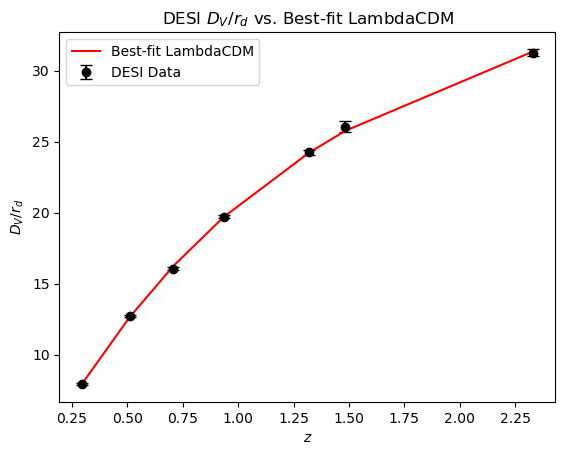

In [15]:
# Use the best-fit parameters from the minimization
model_best = LambdaCDM(best_H0, best_Omega_m, best_Lambda, Omega_radiation=0)
distances_best = CosmologicalDistances(model_best.H)

# Model prediction at the observed redshifts
D_V_model = np.array([distances_best.volume_distance(zi) for zi in z]) / best_r_d

plt.errorbar(z, D_V_obs, yerr=D_V_err, fmt='o', label='DESI Data', color='black', capsize=4)
plt.plot(z, D_V_model, 'r-', label='Best-fit LambdaCDM')
plt.xlabel('$z$')
plt.ylabel(r'$D_V / r_d$')
plt.title('DESI $D_V / r_d$ vs. Best-fit LambdaCDM')
plt.legend()